In [206]:
import pandas as pd
from pandas.plotting import scatter_matrix
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, plot_confusion_matrix

In [207]:
with open('/Users/adam/phd/projects/certificates/data.json', 'r') as json_file:
    data = json.load(json_file)

### Load json features into pandas dataframe

In [208]:
# Create all features and fill a dataframe with them
feature_dict = {x: [] for x in ['category', 'scheme', 'n_updates', 'sec_level', 'sec_level_processed', 'cert_lab', 'n_pages',
                           'cert_date', 'archived_date', 'manufacturer']}
for key, val in data.items():
    cert = data[key]
    feature_dict['category'].append(cert['csv_scan'].get('cc_category', np.nan))
    feature_dict['scheme'].append(cert['csv_scan'].get('cc_scheme', np.nan))
    feature_dict['n_updates'].append(len(cert['csv_scan'].get('maintainance_updates', np.nan)))
    feature_dict['sec_level'].append(cert['csv_scan'].get('cc_security_level', np.nan))
    feature_dict['sec_level_processed'].append(cert['processed'].get('cc_security_level', np.nan))
    feature_dict['cert_lab'].append(cert['processed'].get('cert_lab', np.nan))
    feature_dict['cert_date'].append(cert['csv_scan'].get('cc_certification_date', np.nan))
    feature_dict['archived_date'].append(cert['csv_scan'].get('cc_archived_date', np.nan))
    feature_dict['manufacturer'].append(cert['processed'].get('cc_manufacturer_simple', np.nan))

    meta_scan = cert.get('pdfmeta_scan') or {}
    n_pages = meta_scan.get('pdf_number_of_pages', np.nan)
    feature_dict['n_pages'].append(n_pages)
df = pd.DataFrame(data=feature_dict)

### Preprocess features

In [209]:
# Map security level into ordered categories
sec_level_dict = {'None': np.nan, 'EAL1': 0, 'EAL1+': 1, 'EAL2': 2, 'EAL2+': 3, 'EAL3': 4, 'EAL3+': 4, 'EAL4': 5, 'EAL4+': 6, 'EAL5': 7, 'EAL5+': 8, 'EAL6': 9, 'EAL6+': 10, 'EAL7': 11, 'EAL7+': 12}
df['sec_level_cat'] = df.sec_level_processed.map(sec_level_dict)
sec_level_median = df['sec_level_cat'].loc[df.sec_level_cat != -1].median()
df['sec_level_cat'].fillna(sec_level_median, inplace=True)

# Fill-in missing values of n_pages with median and categorize into intervals (ordered)
n_pages_median = df.n_pages.median()
df.n_pages.fillna(n_pages_median, inplace=True)

df['n_pages_cat'] = pd.cut(df.n_pages, [0, 10, 15, 30, 40, 50, 5000], labels=[x for x in range(6)])
df.n_pages_cat = df['n_pages_cat'].astype('int64')

# Categories number of updates to intervals
df['n_updates_cat'] = pd.cut(df.n_updates, [-1, 0, 1, 2, 3, 100], labels=[x for x in range(5)])
df['n_updates_cat'] = df['n_updates_cat'].astype('int64')

# Create year of certification feature
df.cert_date = pd.to_datetime(df.cert_date)
df.archived_date = pd.to_datetime(df.archived_date)
df['cert_year'] = df.cert_date.dt.year

# Drop rows that didn't yet been archived
#df = df.loc[~df.archived_date.isnull(), :]

# Select timedelta in months between cert date and archived date
#df['n_days_valid'] = df.archived_date - df.cert_date

### Basic visualisations

In [ ]:
# Show histogram
%matplotlib inline
df.hist(bins=20, figsize=(20, 15))
plt.show()

In [210]:
# Show correlations between numerical features and the target feature
df.corr()['sec_level_cat'].sort_values(ascending=False)

sec_level_cat    1.000000
n_pages_cat      0.213559
n_updates_cat    0.189886
n_updates        0.173871
cert_year        0.167917
n_pages          0.152911
Name: sec_level_cat, dtype: float64

### Prepare training and test set

In [211]:
features = df.loc[:, ['category', 'scheme', 'n_updates_cat', 'sec_level_cat', 'n_pages_cat', 'cert_year']]

features.category = features.category.astype('category').cat.codes
features.scheme = features.scheme.astype('category').cat.codes
#features.sec_level = features.sec_level.astype('category').cat.codes
#features.n_days_valid = features.n_days_valid.apply(lambda x: float(x.days))

labels = np.array(features['sec_level_cat']) # we can also predict sec_level for instance
features.drop('sec_level_cat', axis=1, inplace=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state=42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (3284, 5)
Training Labels Shape: (3284,)
Testing Features Shape: (821, 5)
Testing Labels Shape: (821,)


### Build RandomForest classifier / regressor

In [216]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
acc = accuracy_score(predictions, test_labels, normalize=True)
print(acc)

0.5907429963459196


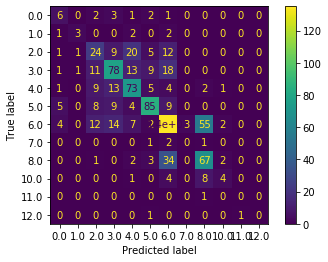

In [213]:
plot_confusion_matrix(rf, test_features, test_labels)

In [ ]:
rf = RandomForestRegressor(n_estimators=70)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
mae = mean_absolute_error(predictions, test_labels)
mse = mean_squared_error(predictions, test_labels)
print(f'MAE: {mae}\nMSE: {mse}')

In [ ]:
list(rf.feature_importances_)